#### Import Libraries

In [96]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

/home/penscola/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [50]:
data = pd.read_csv('../data/data.csv')

In [51]:
features = [
    'Make', 'Model', 'Year', 'Engine HP', 'Engine Cylinders',
    'Transmission Type', 'Vehicle Style', 'highway MPG', 'city mpg', 'MSRP'
]

In [52]:
data = data[features]

In [53]:
data.columns = data.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(data.dtypes[data.dtypes == 'object'].index)

for c in categorical_columns:
    data[c] = data[c].str.lower().str.replace(' ', '_')

data['engine_hp'] = data['engine_hp'].fillna(0)
data['engine_cylinders'] = data['engine_cylinders'].fillna(0)

In [54]:
data = data.rename(columns={'msrp': 'price'})
data.columns = data.columns.str.replace(' ', '_').str.lower()

In [55]:
data_class = data.copy()
mean = data_class['price'].mean()

data_class['above_average'] = np.where(data_class['price']>=mean,1,0)

data_class = data_class.drop(['price'], axis=1)

data_class

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,above_average
0,bmw,1_series_m,2011,335.0,6.0,manual,coupe,26,19,1
1,bmw,1_series,2011,300.0,6.0,manual,convertible,28,19,1
2,bmw,1_series,2011,300.0,6.0,manual,coupe,28,20,0
3,bmw,1_series,2011,230.0,6.0,manual,coupe,28,18,0
4,bmw,1_series,2011,230.0,6.0,manual,convertible,28,18,0
...,...,...,...,...,...,...,...,...,...,...
11909,acura,zdx,2012,300.0,6.0,automatic,4dr_hatchback,23,16,1
11910,acura,zdx,2012,300.0,6.0,automatic,4dr_hatchback,23,16,1
11911,acura,zdx,2012,300.0,6.0,automatic,4dr_hatchback,23,16,1
11912,acura,zdx,2013,300.0,6.0,automatic,4dr_hatchback,23,16,1


In [56]:
df_full_train, df_test = train_test_split(data_class, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

del df_train['above_average']
del df_val['above_average']
del df_test['above_average']

In [57]:
df_full_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9531 entries, 2711 to 235
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   make               9531 non-null   object 
 1   model              9531 non-null   object 
 2   year               9531 non-null   int64  
 3   engine_hp          9531 non-null   float64
 4   engine_cylinders   9531 non-null   float64
 5   transmission_type  9531 non-null   object 
 6   vehicle_style      9531 non-null   object 
 7   highway_mpg        9531 non-null   int64  
 8   city_mpg           9531 non-null   int64  
 9   above_average      9531 non-null   int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 819.1+ KB


In [58]:
categorical = ['make', 'model', 'transmission_type', 'vehicle_style']
numerical = ['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']

In [59]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

/home/penscola/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [60]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8959295006294586

#### Accuracy and dummy model

* Evaluate the model on different thresholds
* Check the accuracy of dummy baselines

In [62]:
accuracy_score(y_val, y_pred >= 0.5)

0.8959295006294586

In [63]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.762
0.10 0.824
0.15 0.847
0.20 0.861
0.25 0.877
0.30 0.885
0.35 0.889
0.40 0.895
0.45 0.894
0.50 0.896
0.55 0.889
0.60 0.889
0.65 0.885
0.70 0.878
0.75 0.877
0.80 0.871
0.85 0.857
0.90 0.843
0.95 0.822
1.00 0.726


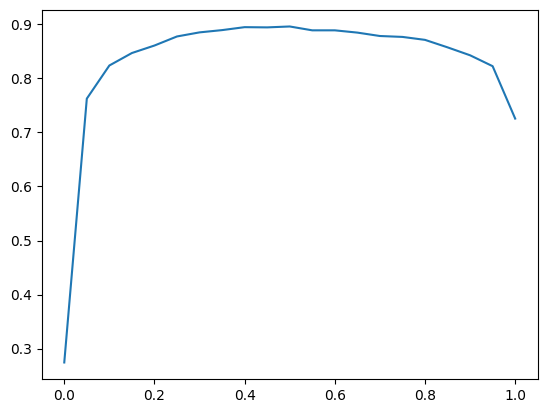

In [64]:
plt.plot(thresholds, scores)

#### Confusion table

* Different types of errors and correct decisions
* Arranging them in a table

In [65]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [66]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [67]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [68]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[1627,  102],
       [ 146,  508]])

In [69]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.68, 0.04],
       [0.06, 0.21]])

#### Precision and Recall

In [70]:
p = tp / (tp + fp)
p

0.8327868852459016

In [71]:
r = tp / (tp + fn)
r

0.7767584097859327

#### ROC Curves

#### TPR and FRP

In [72]:
tpr = tp / (tp + fn)
tpr

0.7767584097859327

In [73]:
fpr = fp / (fp + tn)
fpr

0.058993637941006365

In [74]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [75]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

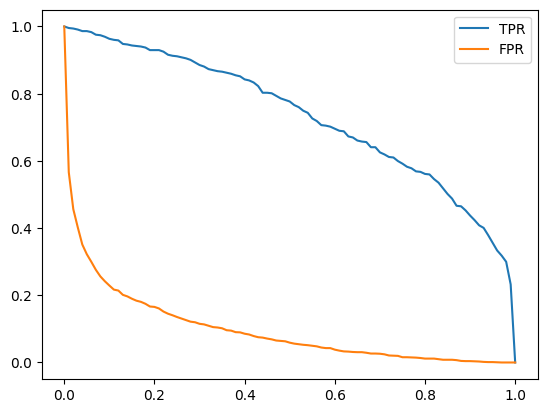

In [76]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

#### Random model

In [77]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [78]:
((y_rand >= 0.5) == y_val).mean()

0.49097775912715064

In [79]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [105]:
#@ ADDING THE COLUMNS:
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

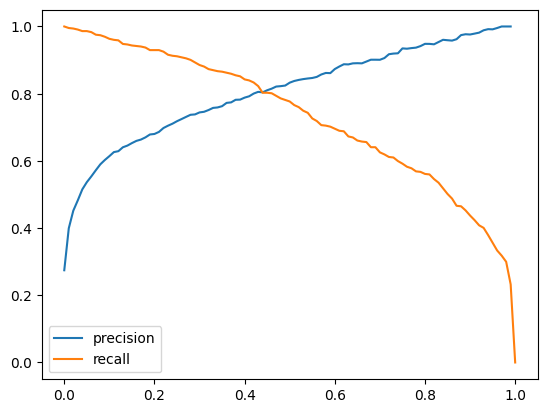

In [106]:
#@ INSPECTING THE CURVES:
plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')

plt.legend()
plt.show()
     

In [107]:
#@ GETTING F1 SCORES:
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)
     

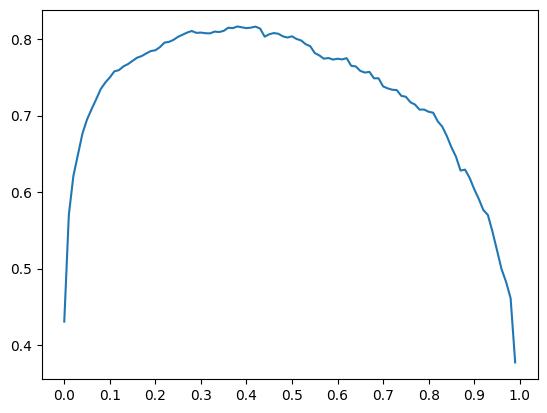

In [108]:

#@ INSPECTING F1 SCORE:
plt.plot(df_scores.threshold, df_scores.f1)
plt.xticks(np.linspace(0, 1, 11))
plt.show()

In [80]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

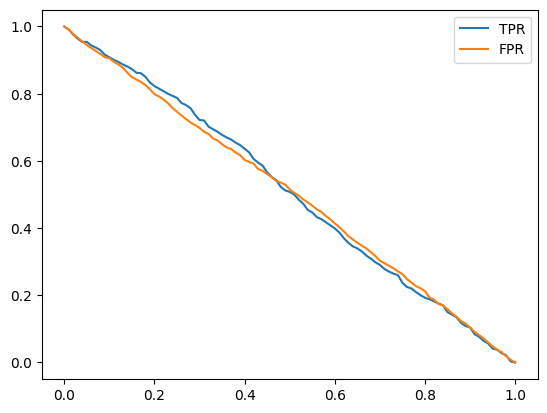

In [81]:
plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
plt.legend()

#### Ideal model

In [82]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(1729, 654)

In [83]:

y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal

y_ideal_pred = np.linspace(0, 1, len(y_val))

In [84]:
1 - y_val.mean()

0.7255560218212338

In [85]:
accuracy_score(y_ideal, y_ideal_pred >= 0.726)

0.9995803608896349

In [86]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,654,1729,0,0,1.000000,1.000000
10,0.1,654,1490,0,239,1.000000,0.861770
20,0.2,654,1252,0,477,1.000000,0.724118
30,0.3,654,1014,0,715,1.000000,0.586466
40,0.4,654,776,0,953,1.000000,0.448814
50,0.5,654,538,0,1191,1.000000,0.311163
60,0.6,654,299,0,1430,1.000000,0.172932
70,0.7,654,61,0,1668,1.000000,0.035281
80,0.8,477,0,177,1729,0.729358,0.000000
90,0.9,239,0,415,1729,0.365443,0.000000


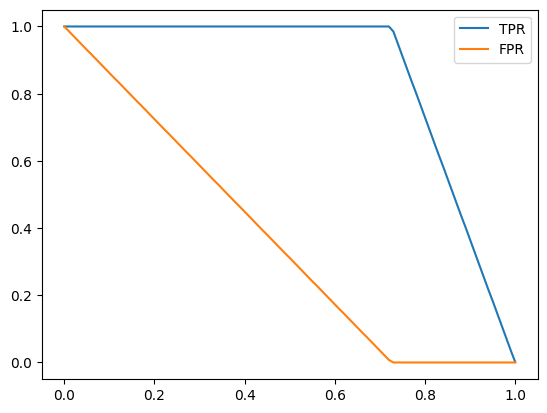

In [87]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')
plt.legend()

#### Putting everything together

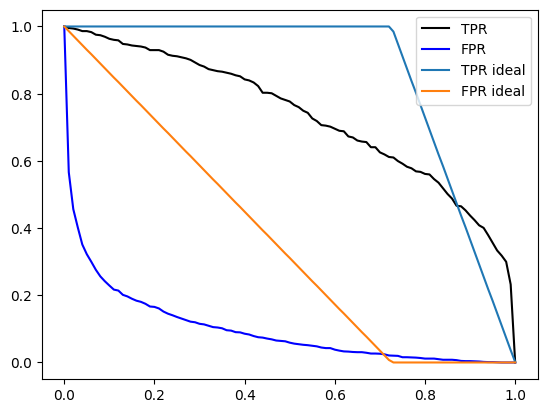

In [88]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR', color='black')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR', color='blue')

plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR ideal')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR ideal')

# plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR random', color='grey')
# plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR random', color='grey')

plt.legend()

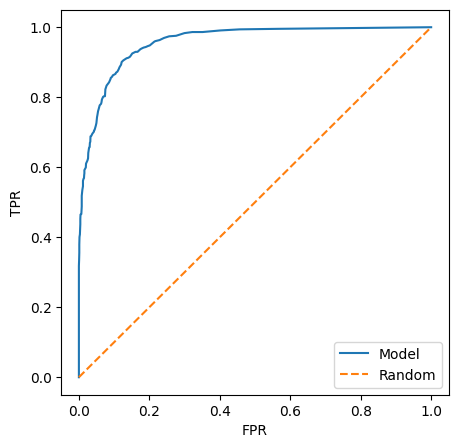

In [89]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

In [91]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

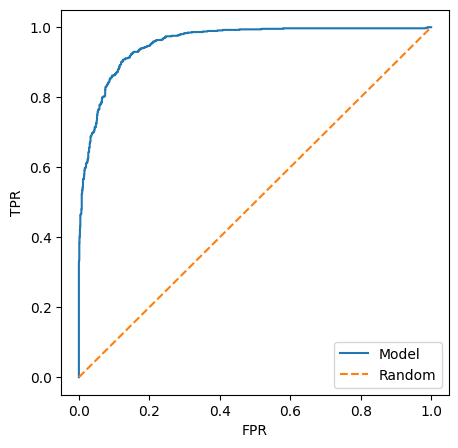

In [92]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

#### ROC AUC

* Area under the ROC curve - useful metric
* Interpretation of AUC

In [94]:
#@ CALCULATING ROC AUC SCORE:
for c in numerical:
    auc = roc_auc_score(y_train, df_train[c])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[c])
    print('%9s, %.3f' % (c, auc))

     year, 0.688
engine_hp, 0.917
engine_cylinders, 0.766
highway_mpg, 0.633
 city_mpg, 0.673


#### Cross-Validation

* Evaluating the same model on different subsets of data
* Getting the average prediction and the spread within predictions

In [95]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [97]:
dv, model = train(df_train, y_train, C=1.0)

/home/penscola/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [98]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [99]:
y_pred = predict(df_val, dv, model)

In [101]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.above_average.values
        y_val = df_val.above_average.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

 14%|█▍        | 1/7 [00:11<01:06, 11.10s/it]

C=0.001 0.935 +- 0.003


 29%|██▊       | 2/7 [00:33<01:27, 17.48s/it]

C=0.01 0.952 +- 0.003


 43%|████▎     | 3/7 [01:58<03:14, 48.52s/it]

C=0.1 0.972 +- 0.001


/home/penscola/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/penscola/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

C=0.5 0.980 +- 0.002


/home/penscola/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/penscola/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

C=1 0.979 +- 0.003


/home/penscola/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/penscola/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

C=5 0.979 +- 0.003


/home/penscola/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/penscola/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

C=10 0.980 +- 0.003


In [102]:
scores

[0.9763908368396447,
 0.9798373796015307,
 0.9817968880709387,
 0.9766340416039262,
 0.9850302475302475]

In [103]:
dv, model = train(df_full_train, df_full_train.above_average.values, C=1.0)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

/home/penscola/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9784552296054954